### 时间序列预测实战

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from matplotlib import  pyplot as plt 
%matplotlib inline

In [ ]:
num_time_steps = 50
input_size = 1
hidden_size = 16
output_size = 1
lr = 0.01

### Net

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=1,
            batch_first=True,   # 表示使用 [batch, seq_len, feature] 形式的输入序列
                                # 默认为 False，即默认使用 [seq_len, batch, feature] 形式的输入序列
        )
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq_len, h_size] => [seq_len, h_size]
        out = out.view(-1, hidden_size)
        # [seq_len, h_size] => [seq_len, 1]
        out = self.linear(out)      
        # 在dim=0的维度前面插入一个维度
        # => [1, seq_len, 1] 使得输出结果与y的形状保持一致，方便后续与y进行损失值的计算
        out = out.unsqueeze(dim=0)  
        return out, hidden_prev 

### Train

In [ ]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

# 初始记忆单元（初始隐藏状态） h0:[]
hidden_prev = torch.zeros(1, 1, hidden_size)

for iter in range(6000):
    # 初始化一个0-3的随机数
    start = np.random.randint(3, size=1)[0]
  
    # np.linspace：生成指定区间内的等间隔数值序列
    #   3个参数分别表示数值序列的起始值、结束值、数值序列的元素个数
    time_steps = np.linspace(start, start+10, num_time_steps)

    data = np.sin(time_steps)
    data = data.reshape(num_time_steps, 1)
    x = torch.tensor(data[:-1]).float().view(1, num_time_steps-1, 1)    # x:[batch, seq_len, feature]
    y = torch.tensor(data[1:]).float().view(1, num_time_steps-1, 1)     # y:[batch, seq_len, feature]

    output, hidden_prev = model(x, hidden_prev)
    hidden_prev = hidden_prev.detach()

    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 100 ==0:
        print(f"Iteration: {iter}, loss: {loss.item()}")
    

### Predict

In [ ]:
start = np.random.randint(3, size=1)[0]
time_steps = np.linspace(start, start + 10, num_time_steps)
data = np.sin(time_steps)
data = data.reshape(num_time_steps, 1)
x = torch.tensor(data[:-1]).float().view(1, num_time_steps - 1, 1)
y = torch.tensor(data[1:]).float().view(1, num_time_steps - 1, 1)

In [ ]:
predictions = []
input = x[:, 0, :]
for _ in range(x.shape[1]):
    input = input.view(1, 1, 1)
    (pred, hidden_prev) = model(input, hidden_prev)
    input = pred
    predictions.append(pred.detach().numpy().ravel()[0])  # numpy中的ravel()方法，将多维数组展平为一维

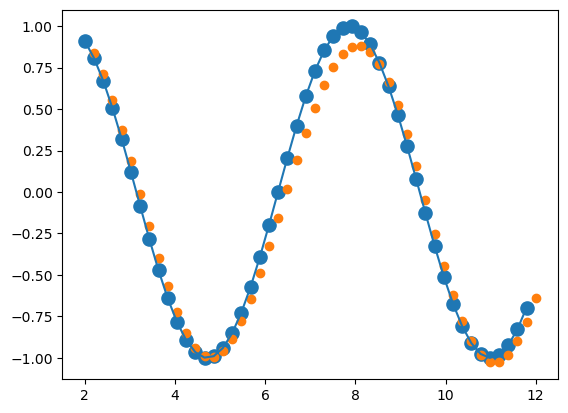

In [43]:
x = x.data.numpy().ravel()
#  = y.data.numpy()
plt.scatter(time_steps[:-1], x.ravel(), s=90)
plt.plot(time_steps[:-1], x.ravel())
plt.scatter(time_steps[1:], predictions)
plt.show()